<a href="https://colab.research.google.com/github/ksydata/DB_FEC_CreditScoringSystem/blob/main/%5BNCB%5D_Preprocessing_PolynomialRegression_then_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

은행과 같은 금융기관의 리테일 금융소비자(개인 고객)에게 가계신용대출(Home Credit Loan)을 할 경우 고객이 대출금을 상환할지 Target 변수 분류 및 대출금액 예측 프로젝트

In [ ]:

import pandas as pd
import numpy as np
from numpy.linalg import eig
import missingno as msno
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.interpolate import interp1d
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
  # [불균형한 분포도를 가진 집합이므로 Stratified K-Fold 교차검증]
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import plotly.express as px
from sklearn.feature_selection import *
  # [사이킷런 특징선택 세부 클래스의 모든 함수 호출]
# from impyute.imputation.cs import mice
  # [실행 오류]
from autoimpute.imputations import MiceImputer
from scipy.stats import chi2_contingency
# from impyute.imputation.cs import mice
  # [실행 오류]
# pip install autoimpute
from autoimpute.imputations import MiceImputer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
HCD = pd.read_csv("/content/drive/MyDrive/application_train.csv", index_col = False)

In [ ]:
HCD = pd.DataFrame(HCD)
HCD.iloc[:, 0:30].info()
HCD.iloc[:, 30:60].info()
HCD.iloc[:, 60:122].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  307511 non-null  int64  
 1   TARGET                      307511 non-null  int64  
 2   NAME_CONTRACT_TYPE          307511 non-null  object 
 3   CODE_GENDER                 307511 non-null  object 
 4   FLAG_OWN_CAR                307511 non-null  object 
 5   FLAG_OWN_REALTY             307511 non-null  object 
 6   CNT_CHILDREN                307511 non-null  int64  
 7   AMT_INCOME_TOTAL            307511 non-null  float64
 8   AMT_CREDIT                  307511 non-null  float64
 9   AMT_ANNUITY                 307499 non-null  float64
 10  AMT_GOODS_PRICE             307233 non-null  float64
 11  NAME_TYPE_SUITE             306219 non-null  object 
 12  NAME_INCOME_TYPE            307511 non-null  object 
 13  NAME_EDUCATION

In [ ]:
CodeBook = pd.read_csv("/content/drive/MyDrive/HomeCredit_columns_description.csv", index_col = False, encoding = "Latin-1")
'''
[전체 데이터프레임 조회 목적]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
Past.iloc[:, [6, 15, 23]]
'''

"\n[전체 데이터프레임 조회 목적]\n\npd.set_option('display.max_columns', None)\npd.set_option('display.max_row', None)\nPast.iloc[:, [6, 15, 23]]\n"

In [ ]:
Past = pd.read_csv("/content/drive/MyDrive/previous_application.csv", index_col = False)
Past["NAME_CASH_LOAN_PURPOSE"].unique()
Past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

count    7.743700e+05
mean     6.697402e+03
std      2.092150e+04
min     -9.000000e-01
25%      0.000000e+00
50%      1.638000e+03
75%      7.740000e+03
max      3.060045e+06
Name: AMT_DOWN_PAYMENT, dtype: float64

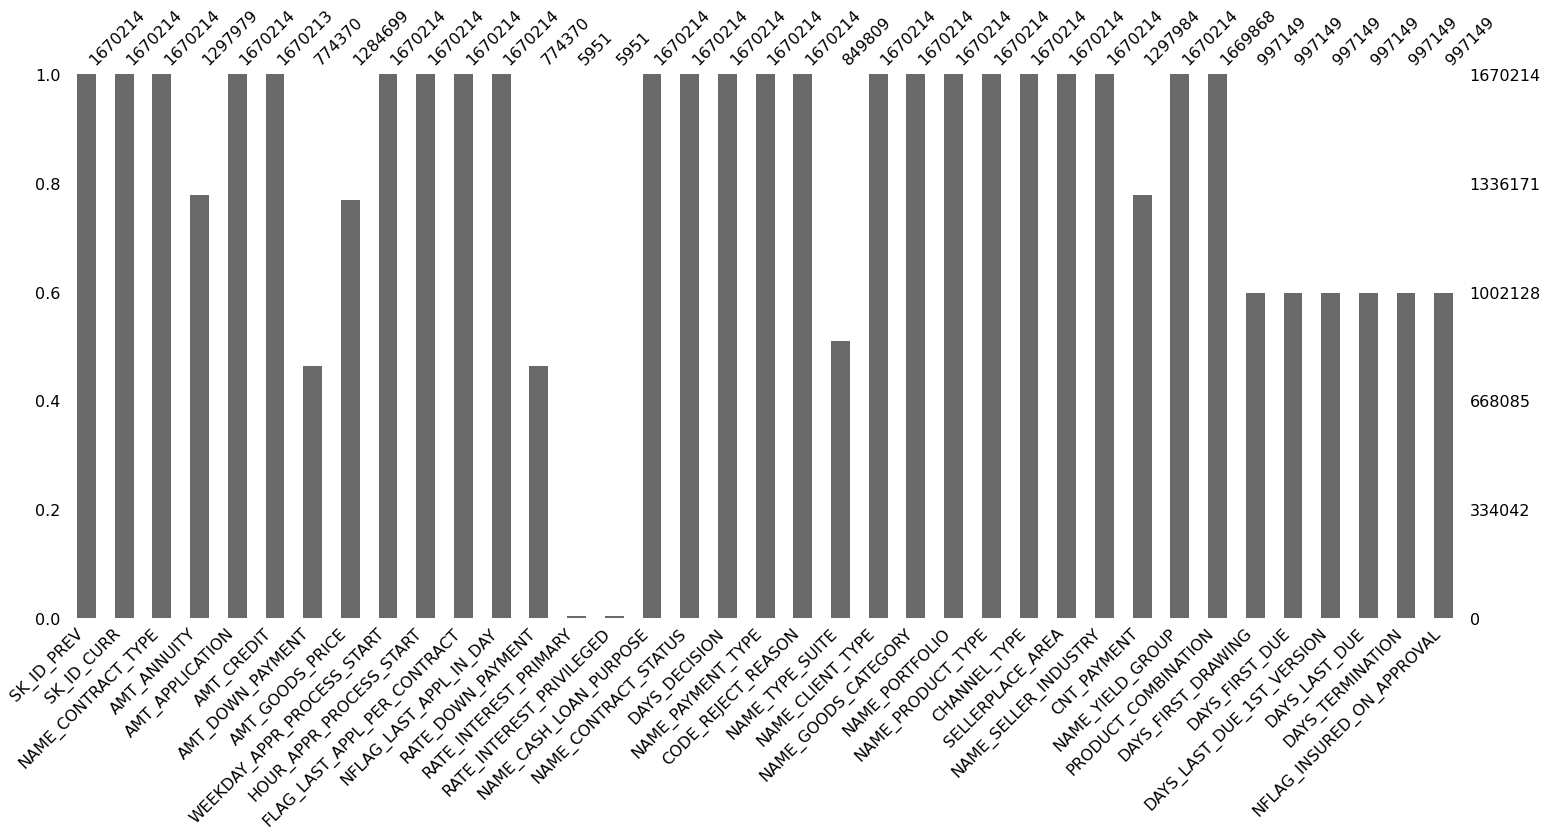

In [ ]:
msno.bar(Past)
Past.groupby(["NAME_CASH_LOAN_PURPOSE", "AMT_DOWN_PAYMENT"]).size()
    # [대출목적이 XAP가 아닌 신용대출의 계약금은 모두 0이므로 Down payment > 0인 행 모두 제거]
    # [관측치 삭제] 주택 매매 목적의 신용대출 데이터 제거 이유는 한국의 여신금융상품 체계는 주택담보대출과 신용대출을 구분하고 있기 때문
Past["AMT_DOWN_PAYMENT"].describe()
    # [Down payment on the previous application]

In [ ]:
index = Past[Past["AMT_DOWN_PAYMENT"] != 0].index
Past.drop(index, inplace = True)

In [ ]:
Past["AMT_DOWN_PAYMENT"].unique()
    # [대출목적이 XAP가 아닌 신용대출의 계약금은 모두 0이므로 Down payment > 0인 행 모두 제거]

array([0.])

In [ ]:
# HCD = HCD.truncate(before = "FLAG_DOCUMENT_21", after = "FLAG_DOCUMENT_2", axis = 1)
    # [ValueError: truncate requires a sorted index]
# HCD.drop(HCD.str.contains("FLAG_DOCUMENT").index, inplace = True)

# [Mutate]
# titanic["adult/child"] = titanic.apply(lambda r: "adult" if r.age >= 20 else "child", axis=1)

  ### HCD 제거목록
    # DAYS_REGISTRATION : 19
    # DAYS_ID_PUBLISH
    # FLAG_MOBIL ~ FLAG_EMAIL
    # CMT_FAMILY_MEMBERS
    # REGION_RATING_CLINET
    # WEEKDAY_APPR_PROCESS_START
    # HOUR_APPR_PROCESS_START
    # REG_REGION_NOT_LIVE_REGION ~ LIVE_CITY_NOT_WORK_CITY
    # DAYS_LAST_PHONE_CHANGE
    # FLAG_DOCUMENT_2~21
    # AMT_REQ_CREDIT_BUREAU
    # EXT_SOURCE_1~3   # 제거
    # 건물정보(APARTMENTS_AVG ~ ),
    * HOUSETYPE_MODE 제외(block of flats : 빌라, terraced house : 단독주택, specific housing : 공공주택)

In [ ]:
HCD.drop(HCD.filter(like = "FLAG_DOCUMENT"), axis = 1, inplace = True)
HCD.drop(HCD.filter(like = "EXT_SOURCE"), axis = 1, inplace = True)
col_names = HCD.columns.values

In [ ]:
values = pd.DataFrame({
    "column" : col_names,
    "number" : range(0, 99)})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
values

,column,number
0,SK_ID_CURR,0
1,TARGET,1
2,NAME_CONTRACT_TYPE,2
3,CODE_GENDER,3
4,FLAG_OWN_CAR,4
5,FLAG_OWN_REALTY,5
6,CNT_CHILDREN,6
7,AMT_INCOME_TOTAL,7
8,AMT_CREDIT,8
9,AMT_ANNUITY,9


In [ ]:
HCD["OBS_30_CNT_SOCIAL_CIRCLE"].head()
HCD["REG_REGION_NOT_LIVE_REGION"].unique()
HCD["REGION_RATING_CLIENT_W_CITY"].unique()
HCD['FLAG_OWN_REALTY'].unique()

array(['Y', 'N'], dtype=object)

In [ ]:
HCD.columns.get_loc("DAYS_REGISTRATION")
    # ["DAYS_REGISTRATION" 변수 제거를 위한 열 번호 추출]

19

In [ ]:
list = []
for i in range(0, 19, 1):
  list.append(i)
for i in [21, 28, 31, 40, 84]:
  list.append(i)
for i in range(88, 92, 1):
  list.append(i)
print(list, end = " ")

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 28, 31, 40, 84, 88, 89, 90, 91] 

In [ ]:
HCD = HCD.iloc[ : , list]
    # [index location]

In [ ]:
HCD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   CNT_CHILDREN                 307511 non-null  int64  
 7   AMT_INCOME_TOTAL             307511 non-null  float64
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307499 non-null  float64
 10  AMT_GOODS_PRICE              307233 non-null  float64
 11  NAME_TYPE_SUITE              306219 non-null  object 
 12  NAME_INCOME_TYPE             307511 non-null  object 
 13 

In [ ]:
    # [PANDAS] get column number from colomn name
    # dataframe.columns.get_loc("<col_name>")

### Past 제거 목록
    # AMT_DOWN_PAYMENT [, 6]
    # WEEKDAY ~ HOUR [, [8,9]]
    # FLAG_LAST_APPL ~ [, [10,11]]NFLAG_LAST_APPL_IN_DAT
    # RATE_DOWN_PAYMENT [, 12]
    # DAYS_DESCION [, 17]
    # NAME_TYPE_SUITE [, 20]
    # NAME_PORTFOLIO [, 23]
    # CHANNEL_TYPE [, 25]
    # NAME_PRODUCT_TYPE (알 수 없음) [, 24]
    # SELLERPLACE_AREA [, 26]
    # CNT_PAYMENT (단위알수없음) [, 28]
    # DAYS~ [, 31:35]
    * NAMED_YEILD_GROUP - 기준금리, 가상금리

In [ ]:
# [Error] KeyError: '[6 8 9 10 11 12 17 20 23 24 25 26 28 31 32 33 34 35] not found in axis'
# Past.drop(columns = [6, 8, 9, 10, 11, 12, 17, 20, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35])

col_names = 0
col_names = Past.iloc[:, [6, 8, 9, 10, 11, 12, 17, 20, 23, 24, 25, 26, 28, 31, 32, 33, 34, 35]].columns.values
col_names

array(['AMT_DOWN_PAYMENT', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT',
       'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION',
       'NAME_TYPE_SUITE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE',
       'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'],
      dtype=object)

In [ ]:
for i in col_names:
  Past.drop(i, axis = 1, inplace = True)

In [ ]:
Past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369854 entries, 0 to 1670209
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   SK_ID_PREV                 369854 non-null  int64  
 1   SK_ID_CURR                 369854 non-null  int64  
 2   NAME_CONTRACT_TYPE         369854 non-null  object 
 3   AMT_ANNUITY                336466 non-null  float64
 4   AMT_APPLICATION            369854 non-null  float64
 5   AMT_CREDIT                 369854 non-null  float64
 6   AMT_GOODS_PRICE            369854 non-null  float64
 7   RATE_INTEREST_PRIMARY      979 non-null     float64
 8   RATE_INTEREST_PRIVILEGED   979 non-null     float64
 9   NAME_CASH_LOAN_PURPOSE     369854 non-null  object 
 10  NAME_CONTRACT_STATUS       369854 non-null  object 
 11  NAME_PAYMENT_TYPE          369854 non-null  object 
 12  CODE_REJECT_REASON         369854 non-null  object 
 13  NAME_CLIENT_TYPE           3

HCD(current application) 및 Past(previous application of home credit loan) 데이터프레임 병합 New Credit Bureau

In [ ]:
NCB = pd.merge(
    left = HCD, right = Past,
    how = "left", on = "SK_ID_CURR"
)

In [ ]:
pd.set_option('display.max_row', 6)
pd.set_option('display.max_columns', None)
NCB

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,2,Business Entity Type 3,block of flats,2.0,2.0,2.0,2.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,NaN,NaN,XAP,Approved,XNA,XAP,New,Vehicles,Auto technology,low_normal,POS other with interest,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,1,School,block of flats,1.0,0.0,1.0,0.0,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,2,Government,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442559,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,2016407.0,Consumer loans,19065.825,223789.5,247423.5,223789.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,low_normal,POS household with interest,1.0
442560,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,1792910.0,Consumer loans,2296.440,18846.0,21456.0,18846.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Mobile,Connectivity,high,POS mobile with interest,0.0
442561,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-16856,-1262,NaN,Laborers,1,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1743609.0,Consumer loans,11090.835,102037.5,112815.0,102037.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0


In [ ]:
NCB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   442562 non-null  int64  
 1   TARGET                       442562 non-null  int64  
 2   NAME_CONTRACT_TYPE_x         442562 non-null  object 
 3   CODE_GENDER                  442562 non-null  object 
 4   FLAG_OWN_CAR                 442562 non-null  object 
 5   FLAG_OWN_REALTY              442562 non-null  object 
 6   CNT_CHILDREN                 442562 non-null  int64  
 7   AMT_INCOME_TOTAL             442562 non-null  float64
 8   AMT_CREDIT_x                 442562 non-null  float64
 9   AMT_ANNUITY_x                442548 non-null  float64
 10  AMT_GOODS_PRICE_x            442153 non-null  float64
 11  NAME_TYPE_SUITE              440939 non-null  object 
 12  NAME_INCOME_TYPE             442562 non-null  object 
 13 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   SK_ID_CURR                   442562 non-null  int64   
 1   TARGET                       442562 non-null  category
 2   NAME_CONTRACT_TYPE_x         442562 non-null  category
 3   CODE_GENDER                  442562 non-null  category
 4   FLAG_OWN_CAR                 442562 non-null  category
 5   FLAG_OWN_REALTY              442562 non-null  category
 6   CNT_CHILDREN                 442562 non-null  int64   
 7   AMT_INCOME_TOTAL             442562 non-null  float64 
 8   AMT_CREDIT_x                 442562 non-null  float64 
 9   AMT_ANNUITY_x                442548 non-null  float64 
 10  AMT_GOODS_PRICE_x            442153 non-null  float64 
 11  NAME_TYPE_SUITE              440939 non-null  category
 12  NAME_INCOME_TYPE             442562 non-null

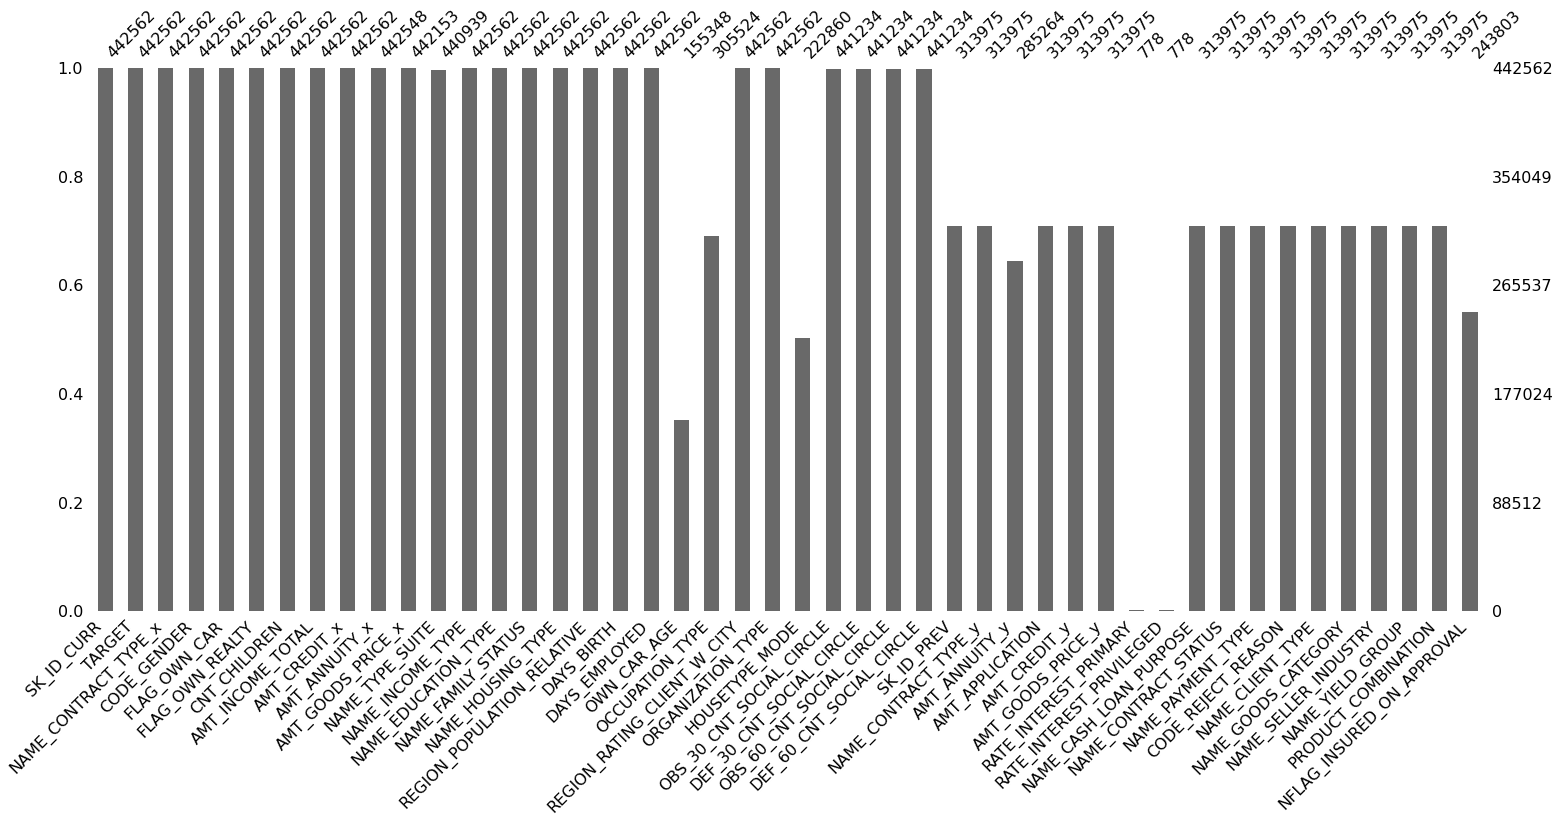

In [ ]:
msno.bar(NCB)
NCB = NCB.astype(
    {"TARGET":"category",
     "NAME_CONTRACT_TYPE_x":"category",
     "CODE_GENDER":"category",
     "FLAG_OWN_CAR":"category",
     "FLAG_OWN_REALTY":"category",
     "NAME_TYPE_SUITE":"category",
     "NAME_INCOME_TYPE":"category",
     "NAME_EDUCATION_TYPE":"category",
     "NAME_FAMILY_STATUS":"category",
     "NAME_HOUSING_TYPE":"category",
     "OCCUPATION_TYPE":"category",
     "REGION_RATING_CLIENT_W_CITY" : "category",
     "ORGANIZATION_TYPE" : "category",
     "HOUSETYPE_MODE" : "category",
     "NAME_CONTRACT_TYPE_y":"category",
     "NAME_CASH_LOAN_PURPOSE":"category",
     "NAME_CONTRACT_STATUS":"category",
     "NAME_PAYMENT_TYPE":"category",
     "CODE_REJECT_REASON":"category",
     "NAME_CLIENT_TYPE":"category",
     "NAME_GOODS_CATEGORY":"category",
     "NAME_SELLER_INDUSTRY":"category",
     "NAME_YIELD_GROUP":"category",
     "PRODUCT_COMBINATION":"category",
     "NFLAG_INSURED_ON_APPROVAL":"category"})
NCB.info()
    # [307511 * 47]이 아닌 [442562 * 47]인 이유

In [ ]:
NCB.sort_values(by = ["SK_ID_CURR"], ascending = True)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,2,Business Entity Type 3,block of flats,2.0,2.0,2.0,2.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,NaN,NaN,XAP,Approved,XNA,XAP,New,Vehicles,Auto technology,low_normal,POS other with interest,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,1,School,block of flats,1.0,0.0,1.0,0.0,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,2,Government,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442560,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,1792910.0,Consumer loans,2296.440,18846.0,21456.0,18846.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Mobile,Connectivity,high,POS mobile with interest,0.0
442559,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,319500.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,NaN,Laborers,2,Business Entity Type 1,block of flats,0.0,0.0,0.0,0.0,2016407.0,Consumer loans,19065.825,223789.5,247423.5,223789.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,low_normal,POS household with interest,1.0
442561,456255,0,Cash loans,F,N,N,0,157500.0,675000.0,49117.5,675000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.046220,-16856,-1262,NaN,Laborers,1,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1743609.0,Consumer loans,11090.835,102037.5,112815.0,102037.5,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0


In [ ]:
pd.set_option('display.max_row', 10)
NCB["SK_ID_CURR"].duplicated()
    # [과거 신용대출을 중복하여 받은 True 고객이 존재하기 때문]
    # [또는 과거 ID인 SK_ID_PREV가 다르지만 현재 ID인 SK_ID_CURR은 동일한 고객이 존재하기 때문]
NCB["duplicate"] = NCB.duplicated(["SK_ID_CURR"])
NCB[NCB["duplicate"] == True]
    # [135051명]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,duplicate
11,100014,0,Cash loans,F,N,Y,1,112500.0,652500.0,21177.0,652500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.022800,-10197,-679,NaN,Core staff,2,Medicine,NaN,0.0,0.0,0.0,0.0,1461079.0,Consumer loans,11567.475,119272.500,131868.000,119272.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,New,Computers,Consumer electronics,low_action,POS household without interest,0.0,True
14,100016,0,Cash loans,F,N,Y,0,67500.0,80865.0,5881.5,67500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.031329,-13439,-2717,NaN,Laborers,2,Business Entity Type 2,block of flats,0.0,0.0,0.0,0.0,2824473.0,Consumer loans,7124.040,98500.500,98500.500,98500.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Computers,Consumer electronics,high,POS household with interest,0.0,True
17,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-14583,-203,NaN,Laborers,1,Transport: type 2,block of flats,0.0,0.0,0.0,0.0,2704445.0,Consumer loans,94906.035,536364.000,536364.000,536364.000,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Construction Materials,Construction,low_normal,POS industry with interest,0.0,True
18,100018,0,Cash loans,F,N,Y,0,189000.0,773680.5,32778.0,679500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010006,-14583,-203,NaN,Laborers,1,Transport: type 2,block of flats,0.0,0.0,0.0,0.0,1251951.0,Consumer loans,4180.365,36805.365,36805.365,36805.365,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Mobile,Connectivity,low_normal,POS mobile without interest,0.0,True
21,100020,0,Cash loans,M,N,N,0,108000.0,509602.5,26149.5,387000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.018634,-12931,-1317,NaN,Drivers,2,Government,NaN,0.0,0.0,0.0,0.0,1074770.0,Consumer loans,5729.265,32512.500,35086.500,32512.500,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Repeater,Gardening,Consumer electronics,high,POS household with interest,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442547,456244,0,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,1138500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.031329,-20390,-5326,NaN,NaN,2,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1967722.0,Cash loans,17232.030,135000.000,162778.500,135000.000,NaN,NaN,XNA,Refused,Cash through the bank,HC,Repeater,XNA,XNA,middle,Cash X-Sell: middle,NaN,True
442548,456244,0,Cash loans,F,N,Y,0,261000.0,1303812.0,35982.0,1138500.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.031329,-20390,-5326,NaN,NaN,2,Business Entity Type 3,block of flats,0.0,0.0,0.0,0.0,1035930.0,Cash loans,21177.810,180000.000,191880.000,180000.000,NaN,NaN,Other,Approved,Cash through the bank,XAP,New,XNA,XNA,high,Cash Street: high,0.0,True
442552,456247,0,Cash loans,F,N,Y,0,112500.0,345510.0,17770.5,247500.0,Unaccompanied,Commercial associate,Higher education,Si

In [ ]:
# [Error] TypeError: numpy boolean subtract
# scatter_matrix(NCB, marker = "o", s = 10, alpha = 8, figsize = (12, 8))
# plt.show()

col_list = 0
col_list = []

for col in NCB:
  if NCB[col].dtype == "int":
   col_list.append(col)
for col2 in NCB:
  if NCB[col2].dtype == "float":
    col_list.append(col2)

# [Clean Code] col_list = NCB.select_dtypes(include = ["int64", "float64"]).columns.values

col_list

# 전처리할 때 제거되면 안되는 변수 제외 처리
col_list.pop(0)
col_list.pop(5-1)
col_list.pop(14-2)
col_list.pop(17-3)
    # [pop()은 누적 제거]
col_list
len(col_list)

17

In [ ]:
pca_col = NCB.loc[:, col_list]

In [ ]:
pca_col = pd.DataFrame(StandardScaler().fit_transform(pca_col))
    # [단위 통일을 위한 표준화]
pca_col.columns = col_list
pca_col.isnull().sum()

CNT_CHILDREN                     0
DAYS_BIRTH                       0
DAYS_EMPLOYED                    0
AMT_INCOME_TOTAL                 0
AMT_ANNUITY_x                   14
                             ...  
AMT_ANNUITY_y               157298
AMT_APPLICATION             128587
AMT_GOODS_PRICE_y           128587
RATE_INTEREST_PRIMARY       441784
RATE_INTEREST_PRIVILEGED    441784
Length: 17, dtype: int64

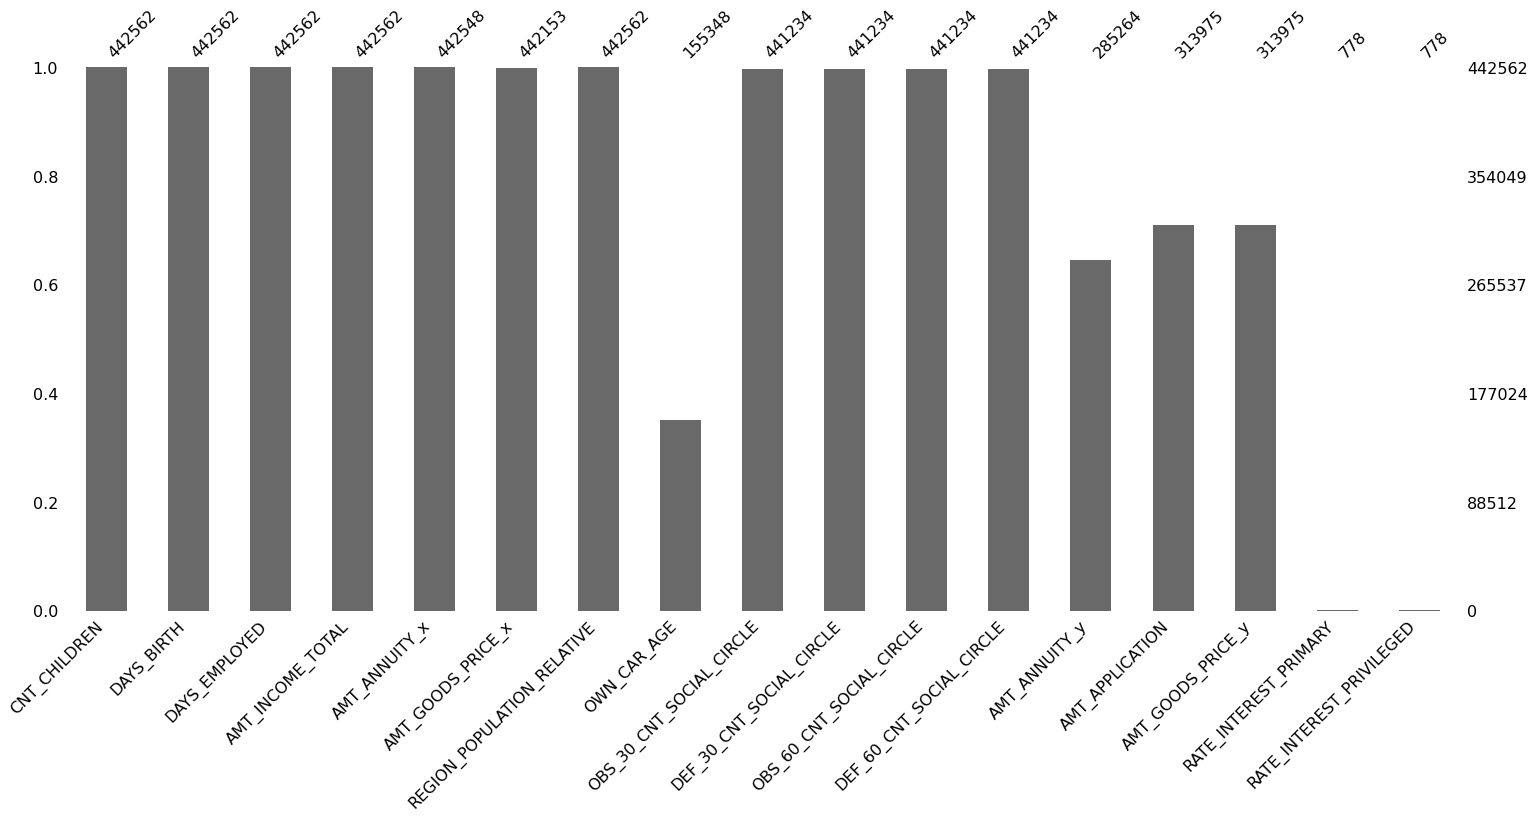

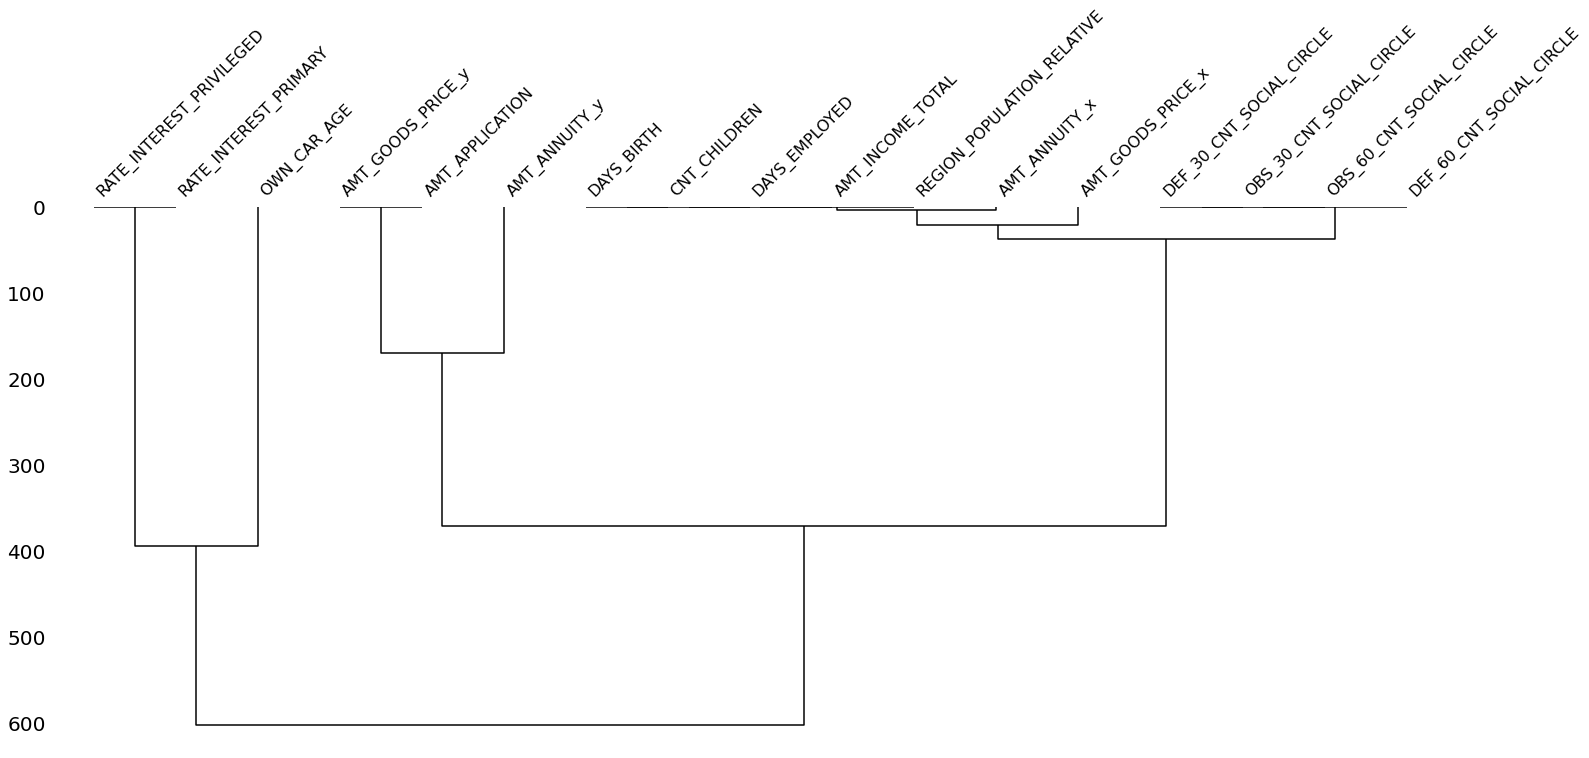

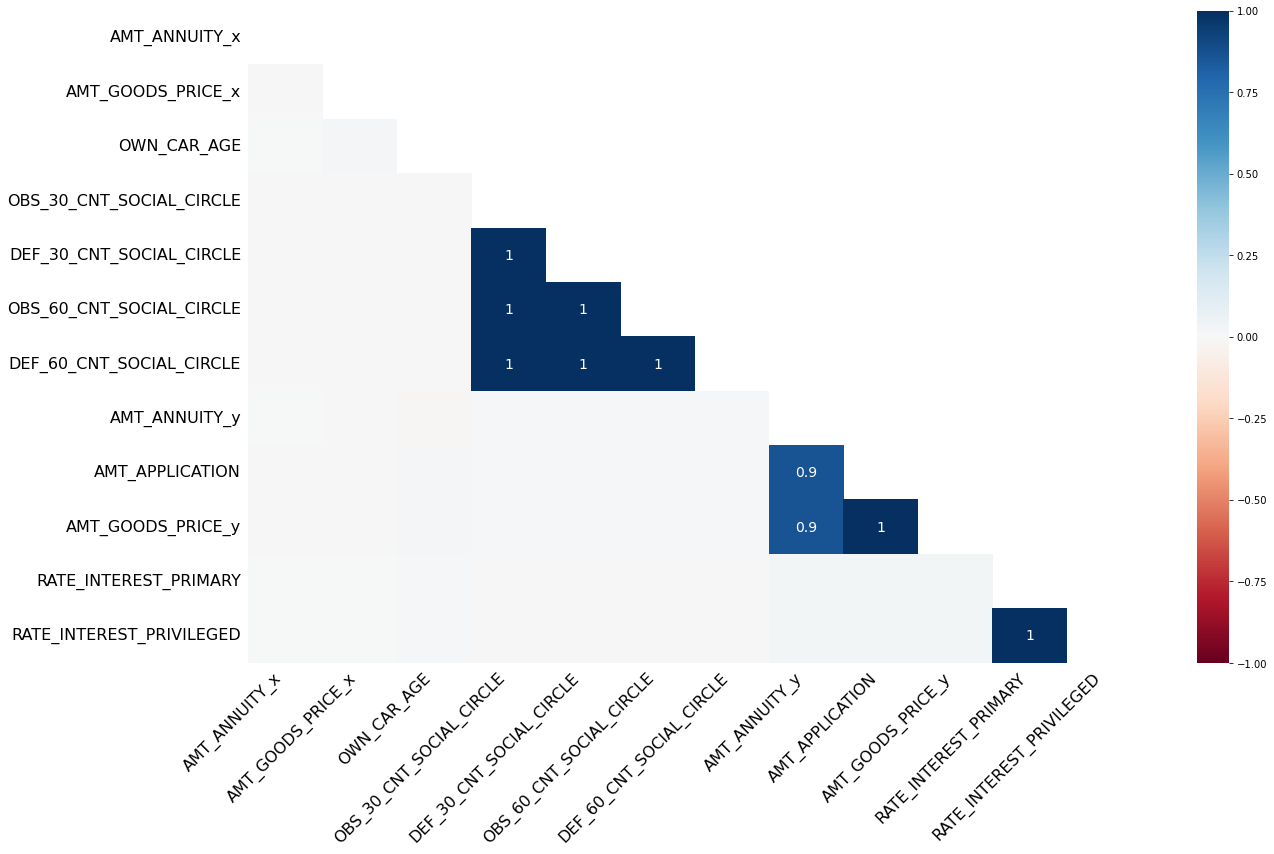

In [ ]:
msno.bar(pca_col)
msno.dendrogram(pca_col)
msno.heatmap(pca_col)
    # [heatmap은 각 컬럼 null의 상관 관계를 측정, 한 변수의 유무 여부가 다른 변수의 유무에 얼마나 큰 영향을 미치는지 측정]
    # OWN_CAR_AGE, AMT_ANNUITY_y, AMT_APPLICATION, AMT_GOODS_PRICE_y, RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED

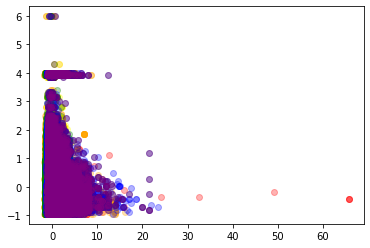

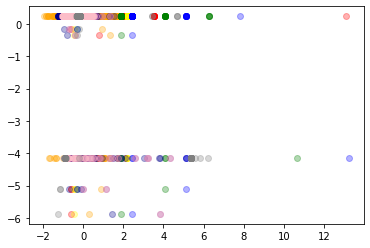

In [ ]:
# "OWN_CAR_AGE"와 상관관계가 있는 변수 간 산점도 시각화 : 선형성 확인 불가능

plt.scatter(x = pca_col.loc[:, "AMT_INCOME_TOTAL"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "red", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_ANNUITY_x"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "orange", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_GOODS_PRICE_x"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "yellow", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "REGION_POPULATION_RELATIVE"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "green", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_ANNUITY_y"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "blue", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_APPLICATION"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "darkblue", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_GOODS_PRICE_y"], y = pca_col.loc[:, ["OWN_CAR_AGE"]], color = "purple", alpha = 0.3)

plt.show()

# "RATE_INTEREST_PRIVILEGED"와 상관관계가 있는 변수 간 산점도 시각화 : 선형성 확인 불가능

plt.scatter(x = pca_col.loc[:, "CNT_CHILDREN"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "red", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "DAYS_BIRTH"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "orange", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "DAYS_EMPLOYED"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "yellow", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "DEF_30_CNT_SOCIAL_CIRCLE"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "green", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "DEF_60_CNT_SOCIAL_CIRCLE"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "blue", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_ANNUITY_y"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "darkblue", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_APPLICATION"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "purple", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "AMT_GOODS_PRICE_y"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "pink", alpha = 0.3)
plt.scatter(x = pca_col.loc[:, "RATE_INTEREST_PRIMARY"], y = pca_col.loc[:, ["RATE_INTEREST_PRIVILEGED"]], color = "grey", alpha = 0.3)

plt.show()

결측치 대체

In [ ]:
# 결측치 대체

pca_col_nrate = pca_col.drop(["RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED", "OWN_CAR_AGE"], axis=1)
    # [결측값이 70% 이상인 변수 제거]

In [ ]:
# [2차 다항식 비선형 회귀분석으로 결측값 예측 보간법]
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html

pca_col_nrate = pca_col_nrate.interpolate(method = "polynomial", order = 2)

In [ ]:
pca_col_nrate.isnull().sum()

CNT_CHILDREN                0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
AMT_INCOME_TOTAL            0
AMT_ANNUITY_x               0
                           ..
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
AMT_ANNUITY_y               0
AMT_APPLICATION             0
AMT_GOODS_PRICE_y           0
Length: 14, dtype: int64

In [ ]:
# OWN_CAR_AGE 결측 행(21개) 제거
pca_col_nrate.dropna(axis=0, inplace=True)

In [ ]:
pca_col_nrate.isnull().sum()
    # [NA 없음]

CNT_CHILDREN                0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
AMT_INCOME_TOTAL            0
AMT_ANNUITY_x               0
                           ..
OBS_60_CNT_SOCIAL_CIRCLE    0
DEF_60_CNT_SOCIAL_CIRCLE    0
AMT_ANNUITY_y               0
AMT_APPLICATION             0
AMT_GOODS_PRICE_y           0
Length: 14, dtype: int64

주성분분석(연속형 특징선택 목적)

In [ ]:
# PCA
# 전체 변수를 주성분으로 하는 pca1 생성 후 최적의 components 찾기

pca1 = PCA(n_components = 14)
pca_array1 = pca1.fit_transform(pca_col_nrate)
pca_nrate_1 = pd.DataFrame(pca_array1, columns = [f"pca{num+1}" for num in range(pca_col_nrate.shape[1])])
pca_nrate_1

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14
0,0.278323,4.552592,0.147706,-1.000741,-4.709167,-0.078337,0.307285,-1.024219,0.731077,0.776943,-0.129099,-0.652152,0.001390,-6.260022e-17
1,6.155727,-0.230960,0.365026,-0.017990,0.183732,-1.386230,0.853684,-0.677244,-3.425507,-0.300237,0.886440,-0.024537,-0.004625,-1.081640e-16
2,7.419297,-0.458507,-2.222576,-2.526667,-0.055214,-0.477891,0.347718,-0.593622,-5.015158,-0.831450,0.436026,-0.003431,-0.000878,2.655412e-15
3,6.155015,0.270417,-1.069367,-1.216085,0.629550,-0.793362,0.487733,-0.610577,-3.819286,-0.683908,-0.457284,-0.052378,-0.006131,-2.000820e-15
4,3.383494,-0.748338,-0.880407,-0.360474,-0.214036,0.415073,-0.396382,-0.463021,-1.595974,-0.891016,0.232776,-0.006992,-0.000487,1.018994e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442557,-0.475928,-0.911186,-2.645885,0.558637,-0.100023,0.368107,-0.195548,0.585545,-0.138052,0.632609,0.130167,-0.004542,-0.001247,1.181719e-17
442558,2.234724,1.779788,0.146910,-0.470113,2.091653,-0.938755,0.565033,-0.862400,-0.027901,-0.092909,-0.061041,-0.149262,-0.018724,-1.620687e-17
442559,1.566727,-0.795003,-0.294256,-1.487492,-0.168183,-0.698568,0.698757,-0.961823,0.103061,0.354459,-0.005925,0.011024,-0.001830,-1.673266e-16
442560,-1.848393,-0.994981,0.042745,-0.840923,-0.209018,-0.632899,0.685195,-0.973305,0.193278,0.307529,-0.048459,0.009851,-0.002166,7.740333e-18


In [ ]:
pd.set_option("display.max_row", None)

In [ ]:
# 주성분의 설명력과 누적기여율(누적분산비) 구하기

result1 = pd.DataFrame({'설명 가능한 분산 비율(고윳값)' : pca1.explained_variance_,
                        '기여율' : pca1.explained_variance_ratio_},
                       index = np.array([f"pca{num+1}" for num in range(pca_col_nrate.shape[1])]))
result1['누적기여율'] = result1['기여율'].cumsum()
result1
    # [pca7 누적기여율 : 0.82]

,설명 가능한 분산 비율(고윳값),기여율,누적기여율
pca1,3.249496e+00,2.209772e-01,0.220977
pca2,2.499824e+00,1.699968e-01,0.390974
pca3,1.889494e+00,1.284923e-01,0.519466
pca4,1.731619e+00,1.177562e-01,0.637222
pca5,1.365189e+00,9.283765e-02,0.730060
pca6,9.843233e-01,6.693745e-02,0.796998
pca7,9.311161e-01,6.331917e-02,0.860317
pca8,8.060815e-01,5.481638e-02,0.915133
pca9,5.205431e-01,3.539876e-02,0.950532
pca10,3.654916e-01,2.485472e-02,0.975387


In [ ]:
pca1.explained_variance_

array([3.24949632e+00, 2.49982352e+00, 1.88949434e+00, 1.73161943e+00,
       1.36518892e+00, 9.84323251e-01, 9.31116083e-01, 8.06081520e-01,
       5.20543101e-01, 3.65491615e-01, 2.24344625e-01, 1.36088168e-01,
       1.51007511e-03, 2.24404475e-32])

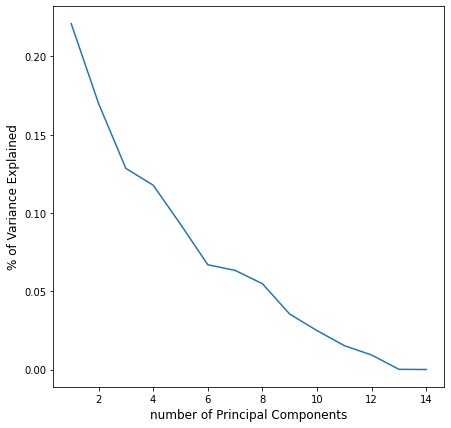

In [ ]:
# Scree Plot

plt.rcParams['figure.figsize']=(7,7)
plt.plot(range(1, pca_col_nrate.shape[1]+1), pca1.explained_variance_ratio_)
plt.xlabel("number of Principal Components", fontsize=12)
plt.ylabel("% of Variance Explained", fontsize=12)
plt.show()
    # [pca 7]

In [ ]:
# n_components = 7

pca = PCA(n_components = 7)
pca_array = pca.fit_transform(pca_col_nrate)
pca_nrate = pd.DataFrame(pca_array, columns = [f"pca{num+1}" for num in range(0,7,1)])

In [ ]:
pca_nrate.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,0.278323,4.552592,0.147706,-1.000741,-4.709167,-0.078337,0.307285
1,6.155727,-0.230960,0.365026,-0.017990,0.183732,-1.386230,0.853684
2,7.419297,-0.458507,-2.222576,-2.526667,-0.055214,-0.477891,0.347718
3,6.155015,0.270417,-1.069367,-1.216085,0.629550,-0.793362,0.487733
4,3.383494,-0.748338,-0.880407,-0.360474,-0.214036,0.415073,-0.396382


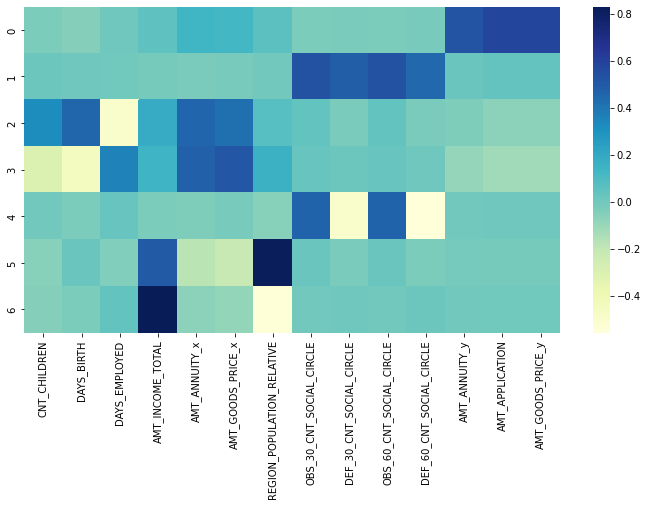

In [ ]:
# PCA 객체의 속성에 저장된 구성요소(원본 데이터 pca_col의 변수 조합)을 해석하는 히트맵

map = pd.DataFrame(pca.components_, columns=pca_col_nrate.columns)
plt.figure(figsize=(12,6))
sns.heatmap(map, cmap = "YlGnBu")
    # [components = 3 : ""]

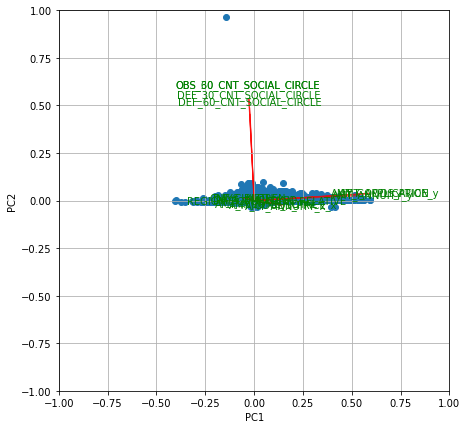

In [ ]:
def biplot(pca, coeff, labels = None):
  pc1 = pca[:, 0]
  pc2 = pca[:, 1]

  n = coeff.shape[0]
  scalepc1 = 1.0/(pc1.max() - pc1.min())
  scalepc2 = 1.0/(pc2.max() - pc2.min())
    # [MinMaxScale]
  plt.scatter(pc1 * scalepc1, pc2 * scalepc2)

  for i in range(n):
    plt.arrow(0, 0, coeff[i, 0], coeff[i, 1],
              color = "r", alpha = 0.5)
      # [loadings : Coefficients]

    if labels is None:
      plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
               "Var" + str(i+1), color = "g", ha = "center", va = "center")
    else:
      plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15,
               labels[i], color = "g", ha = "center", va = "center")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel("PC{}".format(1))
  # [PC1]
plt.ylabel("PC{}".format(2))
  # [PC2]
plt.grid()
biplot(pca_array[:, 0:2], np.transpose(pca.components_[0:2, :]),labels = pca_col_nrate.columns.values)
    # [pca2 : "OBS_80_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCAIL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
    # [pca1 : "AMT_ANNUITY_y", "AMT_APPLICATION", "AMT_GOOD_PRICES_y"]
    # [제거하면 안되는 변수 : "SK_ID_CURR", "AMT_CREDIT_x", "SK_ID_PREV", "AMT_CREDIT_y"]

F-통계량 및 상호정보량 기반 필터링(연속형 특징선택 목적)

In [ ]:
# 필터링 (특징선택)

x1 = 0
x2 = 0

x1 = NCB.select_dtypes(include = ["category", "object"])
x2 = NCB.select_dtypes(include = ["int", "float"])

In [ ]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 21 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  442562 non-null  int64  
 1   CNT_CHILDREN                442562 non-null  int64  
 2   AMT_INCOME_TOTAL            442562 non-null  float64
 3   AMT_CREDIT_x                442562 non-null  float64
 4   AMT_ANNUITY_x               442548 non-null  float64
 5   AMT_GOODS_PRICE_x           442153 non-null  float64
 6   REGION_POPULATION_RELATIVE  442562 non-null  float64
 7   DAYS_BIRTH                  442562 non-null  int64  
 8   DAYS_EMPLOYED               442562 non-null  int64  
 9   OWN_CAR_AGE                 155348 non-null  float64
 10  OBS_30_CNT_SOCIAL_CIRCLE    441234 non-null  float64
 11  DEF_30_CNT_SOCIAL_CIRCLE    441234 non-null  float64
 12  OBS_60_CNT_SOCIAL_CIRCLE    441234 non-null  float64
 13  DEF_60_CNT_SOC

In [ ]:
x2.drop(["RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED", "OWN_CAR_AGE"], axis=1, inplace=True)
    # [NA 70% 이상인 변수 제거]

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
print(x1.columns.values, "\n", x2.columns.values)

['TARGET' 'NAME_CONTRACT_TYPE_x' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'OCCUPATION_TYPE' 'REGION_RATING_CLIENT_W_CITY' 'ORGANIZATION_TYPE'
 'HOUSETYPE_MODE' 'NAME_CONTRACT_TYPE_y' 'NAME_CASH_LOAN_PURPOSE'
 'NAME_CONTRACT_STATUS' 'NAME_PAYMENT_TYPE' 'CODE_REJECT_REASON'
 'NAME_CLIENT_TYPE' 'NAME_GOODS_CATEGORY' 'NAME_SELLER_INDUSTRY'
 'NAME_YIELD_GROUP' 'PRODUCT_COMBINATION' 'NFLAG_INSURED_ON_APPROVAL'] 
 ['SK_ID_CURR' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT_x'
 'AMT_ANNUITY_x' 'AMT_GOODS_PRICE_x' 'REGION_POPULATION_RELATIVE'
 'DAYS_BIRTH' 'DAYS_EMPLOYED' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'DEF_30_CNT_SOCIAL_CIRCLE' 'OBS_60_CNT_SOCIAL_CIRCLE'
 'DEF_60_CNT_SOCIAL_CIRCLE' 'SK_ID_PREV' 'AMT_ANNUITY_y' 'AMT_APPLICATION'
 'AMT_CREDIT_y' 'AMT_GOODS_PRICE_y']


In [ ]:
normalize = MinMaxScaler()
normalize.fit(x2)
  # [정규화]

MinMaxScaler()

In [ ]:
x2 = x2.interpolate(method = "polynomial", order = 2)

In [ ]:
pd.set_option("display.max_rows", 20)
x2 = x2.dropna()
x2.isnull().sum()

SK_ID_CURR                    0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_CREDIT_x                  0
AMT_ANNUITY_x                 0
AMT_GOODS_PRICE_x             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
OBS_30_CNT_SOCIAL_CIRCLE      0
DEF_30_CNT_SOCIAL_CIRCLE      0
OBS_60_CNT_SOCIAL_CIRCLE      0
DEF_60_CNT_SOCIAL_CIRCLE      0
SK_ID_PREV                    0
AMT_ANNUITY_y                 0
AMT_APPLICATION               0
AMT_CREDIT_y                  0
AMT_GOODS_PRICE_y             0
dtype: int64

In [ ]:
y1 = 0
y2 = 0

y1 = x1["TARGET"]
  # [이진 범주형]
y2 = x2["AMT_CREDIT_x"]
  # [연속형]

In [ ]:
x1 = x1.drop("TARGET", axis = 1)
x2 = x2.drop("AMT_CREDIT_x", axis = 1)

In [ ]:
print(y1.isnull().sum(), y2.isnull().sum(), x2.isnull().sum())

0 0 SK_ID_CURR                    0
CNT_CHILDREN                  0
AMT_INCOME_TOTAL              0
AMT_ANNUITY_x                 0
AMT_GOODS_PRICE_x             0
REGION_POPULATION_RELATIVE    0
DAYS_BIRTH                    0
DAYS_EMPLOYED                 0
OBS_30_CNT_SOCIAL_CIRCLE      0
DEF_30_CNT_SOCIAL_CIRCLE      0
OBS_60_CNT_SOCIAL_CIRCLE      0
DEF_60_CNT_SOCIAL_CIRCLE      0
SK_ID_PREV                    0
AMT_ANNUITY_y                 0
AMT_APPLICATION               0
AMT_CREDIT_y                  0
AMT_GOODS_PRICE_y             0
dtype: int64


In [ ]:
# 범주형 x1, y1(TARGET) 및 연속형 x2, y2(AMT_CREDIT_x)의 훈련 및 검증용 데이터 셋 분할

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.2, random_state = 2022)
  # factor(x1) & factor(y1) filtering
x2_train_nf, x2_test_nf, y1_train_nf, y1_test_nf = train_test_split(x2, y1, test_size = 0.2, random_state = 2023)
  # numeric(x2) & factor(y1) filtering
x2_train_nn, x2_test_nn, y2_train_nn, y2_test_nn = train_test_split(x2, y2, test_size = 0.2, random_state = 2023)
  # numeric(x2) & numeric(y2) filtering

In [ ]:
print("x2_train_nf[row, col] :", x2_train_nf.shape)
print("y1_train_nf[row, col] :", y1_train_nf.shape)
print("x2_train_nn[row, col] :", x2_train_nn.shape)
print("y2_train_nn[row, col] :", y2_train_nn.shape)

x2_train_nf[row, col] : (354049, 17)
y1_train_nf[row, col] : (354049,)
x2_train_nn[row, col] : (354049, 17)
y2_train_nn[row, col] : (354049,)


In [ ]:
# F-통계량이 높은 6개 연속형 변수(특징) 선택
  # DV : AMT_CREDIT(대출금액)
  # 분산비율

f_num = SelectKBest(f_regression, k = 6)
f_num.fit(x2_train_nn, y2_train_nn)
  # [인스턴스 f_num(feature_numeric) 생성]
selected_numeric = x2_train_nn.columns[f_num.get_support()]
  # [인스턴스를 인덱스로 사용하여 선택된 6개 변수를 특징 목록 selected_numeric으로 저장]
print("selected_numeric :", selected_numeric)
    # ['AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'AMT_APPLICATION', 'AMT_GOODS_PRICE_y']

# train 데이터와 test 데이터상 필터링 결과가 동질적인지 확인

f_num_test = SelectKBest(f_regression, k = 6)
f_num_test.fit(x2_test_nn, y2_test_nn)
selected_numeric_test = x2_test_nn.columns[f_num_test.get_support()]
print("selected_numeric_test :", selected_numeric_test)

selected_numeric : Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'REGION_POPULATION_RELATIVE', 'AMT_APPLICATION', 'AMT_GOODS_PRICE_y'],
      dtype='object')
selected_numeric_test : Index(['AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'REGION_POPULATION_RELATIVE', 'AMT_ANNUITY_y', 'AMT_GOODS_PRICE_y'],
      dtype='object')


In [ ]:
# 상호 정보량이 높은 6개 연속형 변수(IV, 특징) 선택
  # DV : AMT_CREDIT(대출금액)
  # Frequent Pattern이나 Apriori algorithm처럼 연산량 높다고 판단

f_num2 = SelectKBest(mutual_info_regression, k = 6)
  # [X확률과 Y확률 중 두 사건 X,Y가 동시에 일어날 확률 측정]
    # MutualInformation(X, Y) = P(X∩Y) / P(X)*P(Y)
f_num2.fit(x2_train_nn, y2_train_nn)
selected_numeric2 = x2_train_nn.columns[f_num2.get_support()]
print("selected_numeric2 :", selected_numeric2)
  # ['SK_ID_CURR', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# train 데이터와 test 데이터상 필터링 결과가 동질적인지 확인

f_num2_test = SelectKBest(mutual_info_regression, k = 6)
f_num2_test.fit(x2_test_nn, y2_test_nn)
selected_numeric2_test = x2_test_nn.columns[f_num2_test.get_support()]
print("selected_numeric2_test :", selected_numeric2_test)

selected_numeric2 : Index(['SK_ID_CURR', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED'],
      dtype='object')
selected_numeric2_test : Index(['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH'],
      dtype='object')


In [ ]:
selected_num_list = []

for i in range(0, 6, 1):
    selected_num_list.append(selected_numeric[i])
    if i == 5:
      print(type(selected_num_list))
      print(selected_num_list)
    else: pass

<class 'list'>
['AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'AMT_APPLICATION', 'AMT_GOODS_PRICE_y']


In [ ]:
selected_num_list2 = []

for i in range(0, 6, 1):
    selected_num_list2.append(selected_numeric2[i])
    if i == 5:
      print(type(selected_num_list2))
      print(selected_num_list2)
    else: pass

<class 'list'>
['SK_ID_CURR', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED']


In [ ]:
pca_numeric = ["OBS_80_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCAIL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "AMT_ANNUITY_y", "AMT_APPLICATION", "AMT_GOOD_PRICES_y"]

In [ ]:
print("\n",
      [x for i in selected_num_list for x in selected_num_list2 if i in x],
      "\n",
      [x for i in selected_num_list for x in pca_numeric if i in x],
      "\n",
      [x for i in selected_num_list2 for x in pca_numeric if i in x])


 ['AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE'] 
 ['AMT_APPLICATION'] 
 []




---



In [ ]:
y1_train_nf = pd.DataFrame(y1_train_nf)

In [ ]:
y1_train_nf.groupby(["TARGET"]).size()

TARGET
0    325291
1     28758
dtype: int64

In [ ]:
# F-통계량이 높은 6개 연속형 변수(특징) 선택
  # DV : TARGET(개인/가계신용대출 상환 여부)

f_numfac = SelectKBest(f_classif, k = 6)
f_numfac.fit(x2_train_nf, y1_train_nf)
selected_numfac = x2_train_nf.columns[f_numfac.get_support()]
print("selected_numfac :", selected_numfac)
  # ['AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

# train 데이터와 test 데이터상 필터링 결과가 동질적인지 확인

f_numfac_test = SelectKBest(f_classif, k = 6)
f_numfac_test.fit(x2_test_nf, y1_test_nf)
selected_numfac_test = x2_test_nf.columns[f_numfac_test.get_support()]
print("selected_numfac_test :", selected_numfac_test)

selected_numfac : Index(['AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')
selected_numfac_test : Index(['AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# 상호 정보량이 높은 6개 연속형 변수(IV, 특징) 선택
  # DV : TARGET(개인/가계신용대출 상환 여부)

f_numfac2 = SelectKBest(mutual_info_classif, k = 6)
f_numfac2.fit(x2_train_nf, y1_train_nf)
selected_numfac2 = x2_train_nf.columns[f_numfac2.get_support()]
print("selected_numfac2 :", selected_numfac2)
  # ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

# train 데이터와 test 데이터상 필터링 결과가 동질적인지 확인

f_numfac2_test = SelectKBest(mutual_info_classif, k = 6)
f_numfac2_test.fit(x2_test_nf, y1_test_nf)
selected_numfac2_test = x2_test_nn.columns[f_numfac2_test.get_support()]
print("selected_numfac2_test :", selected_numfac2_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


selected_numfac2 : Index(['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'DAYS_BIRTH', 'DAYS_EMPLOYED'],
      dtype='object')
selected_numfac2_test : Index(['SK_ID_CURR', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED'],
      dtype='object')


In [ ]:
selected_numfac_list = []

for i in range(0, 6, 1):
    selected_numfac_list.append(selected_numfac[i])
    if i == 5:
      print(type(selected_numfac_list))
      print(selected_numfac_list)
    else: pass

<class 'list'>
['AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']


In [ ]:
selected_numfac_list2 = []

for i in range(0, 6, 1):
    selected_numfac_list2.append(selected_numfac2[i])
    if i == 5:
      print(type(selected_numfac_list2))
      print(selected_numfac_list2)
    else: pass

<class 'list'>
['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED']


In [ ]:
# 클린 코드로 바꿀 것

print("\n",
      *[x for i in selected_num_list for x in selected_num_list2 if i in x],
      "\n",
      *[x for i in selected_num_list for x in pca_numeric if i in x],
      "\n",
      *[x for i in selected_num_list2 for x in pca_numeric if i in x],
      "\n",
      *[x for i in selected_numfac_list for x in selected_numfac_list2 if i in x],
      "\n",
      *[x for i in selected_numfac_list for x in pca_numeric if i in x],
      "\n",
      *[x for i in selected_numfac_list2 for x in pca_numeric if i in x],
      "\n",
      *[x for i in selected_num_list for x in selected_numfac_list if i in x],
      "\n",
      *[x for i in selected_num_list for x in selected_numfac_list2 if i in x],
      "\n",
      *[x for i in selected_num_list2 for x in selected_numfac_list if i in x],
      "\n",
      *[x for i in selected_num_list2 for x in selected_numfac_list2 if i in x])
  # [PCA, Fitering과 같은 5가지 특징 선택법에 의해 생성된 변수 리스트 중 2회 이상 공통된 원소(변수)]


 AMT_ANNUITY_x AMT_GOODS_PRICE_x REGION_POPULATION_RELATIVE 
 AMT_APPLICATION 
 
 AMT_GOODS_PRICE_x DAYS_BIRTH DAYS_EMPLOYED 
 DEF_60_CNT_SOCIAL_CIRCLE 
 
 AMT_GOODS_PRICE_x REGION_POPULATION_RELATIVE 
 AMT_INCOME_TOTAL AMT_ANNUITY_x AMT_GOODS_PRICE_x 
 AMT_GOODS_PRICE_x REGION_POPULATION_RELATIVE DAYS_BIRTH DAYS_EMPLOYED 
 SK_ID_CURR AMT_ANNUITY_x AMT_GOODS_PRICE_x DAYS_BIRTH DAYS_EMPLOYED


In [ ]:
featureSelection = {'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE',
                    'AMT_APPLICATION',
                    'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                    'DEF_60_CNT_SOCIAL_CIRCLE',
                    'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE',
                    'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x',
                    'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                    'SK_ID_CURR', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED'}
  # [중복을 허용하지 않는 집합(set) 자료형 이용]

In [ ]:
print(featureSelection, end = ",")
  # ['DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_APPLICATION', 'DAYS_BIRTH', 'AMT_GOODS_PRICE_x']
  # ['DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'REGION_POPULATION_RELATIVE']

{'DAYS_EMPLOYED', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REGION_POPULATION_RELATIVE', 'SK_ID_CURR', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY_x', 'AMT_APPLICATION', 'AMT_GOODS_PRICE_x'},

카이제곱 독립성 검정 기반 필터링 등(범주형 특징선택 목적)

https://data-newbie.tistory.com/446

https://www.jksqm.org/m/journal/view.php?number=2126








In [ ]:
# 범주형(categorical) 결측치 대체
# TARGET 뺄건지?

col_names_2 = NCB.select_dtypes(include = ["category", "object"]).columns.values
categorical = NCB.loc[:,col_names_2]
categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442562 entries, 0 to 442561
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       442562 non-null  category
 1   NAME_CONTRACT_TYPE_x         442562 non-null  category
 2   CODE_GENDER                  442562 non-null  category
 3   FLAG_OWN_CAR                 442562 non-null  category
 4   FLAG_OWN_REALTY              442562 non-null  category
 5   NAME_TYPE_SUITE              440939 non-null  category
 6   NAME_INCOME_TYPE             442562 non-null  category
 7   NAME_EDUCATION_TYPE          442562 non-null  category
 8   NAME_FAMILY_STATUS           442562 non-null  category
 9   NAME_HOUSING_TYPE            442562 non-null  category
 10  OCCUPATION_TYPE              305524 non-null  category
 11  REGION_RATING_CLIENT_W_CITY  442562 non-null  category
 12  ORGANIZATION_TYPE            442562 non-null

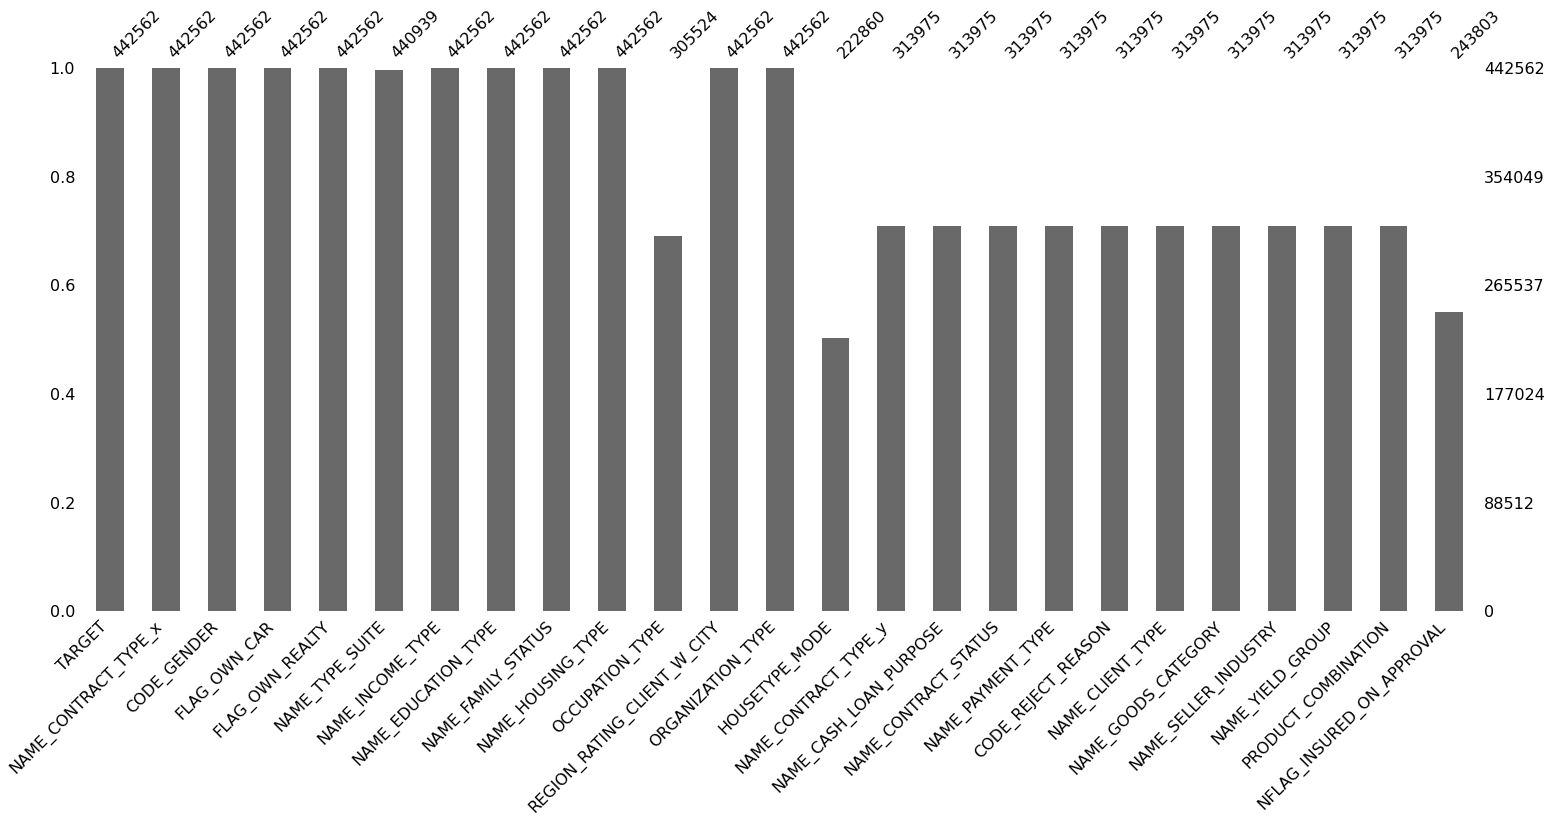

In [ ]:
# 결측치 확인
# pd.set_option('display.max_rows', None)
categorical.isnull().sum()
    # ["NAME_TYPE_SUITE", "OCCUPATION_TYPE", "HOUSETYPE_MODE", "NAME_CONTRACT_TYPE_y", "NAME_CASH_LOAN_PURPOSE", "NAME_CONTRACT_STATUS", "NAME_PAYMENT_TYPE",
    # "CODE_REJECT_REASON", "NAME_CLIENT_TYPE", "NAME_GOODS_CATEGORY", "NAME_SELLER_INDUSTRY", "NAME_YIELD_GROUP", "PRODUCT_COMBINATION", "NFLAG_INSURED_ON_APPROVAL"]
msno.bar(categorical)

In [ ]:
# 442562개 데이터를 20,000개씩 20 fold로 분할
# [변수명 수정하는 방법 찾기]

i = 0
i = []
for i in range(0, len(categorical), 20000):
  globals()["c{}".format(i)] = categorical.iloc[i:i+20000, :]
  #print(globals()["c{}".format(i)].info())
    # [c0, c20000, c40000, c60000, c80000, c100000, c120000, c140000, c160000, c180000, c200000, c220000, c240000, c260000, c280000, c300000, c320000,
    #  c340000, c360000, c380000, c400000, c420000, c440000]

'''
# ERROR : 분할 확인 불가, 크기가 너무 커서 출력이 안되는 것으로 추정, array 형태

def split(arr, n):
  return [arr[i:i+n] for i in range(0, len(arr), n)]

result = split(categorical, 20000)
'''

'\n# ERROR : 분할 확인 불가, 크기가 너무 커서 출력이 안되는 것으로 추정, array 형태\n\ndef split(arr, n):\n  return [arr[i:i+n] for i in range(0, len(arr), n)]\n\nresult = split(categorical, 20000)\n'

### 범주형 자료 결측치 대체


[Most poplular way]
- Replace with most frequent value
- 'missing' 이라는 새로운 카테고리 만들기

[Reference]

https://www.analyticsvidhya.com/blog/2021/04/how-to-handle-missing-values-of-categorical-variables/

    1. Delete the observations
    2. Replace with most frequent value
    3. Develop a model to predict missing values

---
[Algorithm & ]

1. Using Categorical Imputer of sklearn-pandas library https://www.geeksforgeeks.org/pandas-filling-nan-in-categorical-data/

  Using Categorical Imputer of feature-engine library https://www.kaggle.com/code/ilayaraja07/6-categorical-imputation, https://github.com/feature-engine/feature_engine/blob/main/feature_engine/imputation/categorical.py

  * sklearn_pandas, feature_engine library 모두 최빈값으로 대체한 것
  * It replaces missing values with the most frequent ones in that column.


2. 범주별 구성비율의 확률로 채우기 https://rfriend.tistory.com/613

  * random하게 범주형 채우는 것이기 때문에 오차 발생이 우려됨.

3. Datawig
https://choigww.github.io/data%20preprocessing/2021/02/18/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EA%B2%B0%EC%B8%A1%EC%B9%98-%EC%B1%84%EC%9A%B0%EB%8A%94-6%EA%B0%80%EC%A7%80-%EB%B0%A9%EB%B2%95/

  * 상관성이 높거나 타깃 컬럼에 대한 정보를 가지고 있는 변수들을 지정

  * [단점] 단일 컬럼에 대해서 적용 가능 (Single Column Imputation)

4. 더미화 후 MICE https://continuous-development.tistory.com/160
  * 더미변수화하면 category가 feature가 돼서 차원 축소 불가



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 3.9 MB/s 


In [ ]:
'''
# [Trial&Error_1] CategoricalImputer - feature_engine
# [오류 없이 실행되지만 most frequent로 대체 되는 기법]

#!pip install feature-engine
from feature_engine.imputation import CategoricalImputer

imputer = CategoricalImputer()
    # [클래스 객체 생성]
c0_im = imputer.fit_transform(c0)
c0_im.isnull().sum()
'''

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


TARGET                       0
NAME_CONTRACT_TYPE_x         0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
FLAG_OWN_REALTY              0
                            ..
NAME_GOODS_CATEGORY          0
NAME_SELLER_INDUSTRY         0
NAME_YIELD_GROUP             0
PRODUCT_COMBINATION          0
NFLAG_INSURED_ON_APPROVAL    0
Length: 25, dtype: int64

In [ ]:
'''
# [Trial&Error_2] MiceImputer
# [random forest 기반이 아님]

#!pip install autoimpute
from autoimpute.imputations import MiceImputer
imp = MiceImputer()
c0_df = imp.fit_transform(c0)
'''

In [ ]:
'''
# [Trial&Error_3] CategoricalImputer - sklearn-pandas library
# [Error] ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

from sklearn_pandas import CategoricalImputer
imputer_ca = CategoricalImputer()
    # [imputer_ca 객체 생성]
c0_im = imputer_ca.fit_transform(c0)

'''

'\n# [Trial&Error_1] CategoricalImputer - sklearn-pandas library\n# [Error] ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().\n\nfrom sklearn_pandas import CategoricalImputer\nimputer_ca = CategoricalImputer()\n    # [imputer_ca 객체 생성]\nc0_im = imputer_ca.fit_transform(c0)\n\n'

In [ ]:
'''
# [Trial&Error_4] IterativeImputer
# [Error] ValueError: could not convert string to float: 'Cash loans'

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
imputer.fit(c0)
c0_df = imputer.transform(c0)
c0_df.info()
'''

"\n# [Trial&Error_2] IterativeImputer\n# [Error] ValueError: could not convert string to float: 'Cash loans'\n\nfrom sklearn.experimental import enable_iterative_imputer\nfrom sklearn.impute import IterativeImputer\n\nimputer = IterativeImputer()\nimputer.fit(c0)\nc0_df = imputer.transform(c0)\nc0_df.info()\n"

In [ ]:
'''
# [Trial&Error_5] Datawig

  [Datawig 를 위한 전처리 과정]
    1) 범주형 대체를 위해 차원이 줄어든 Numeric 변수와 모든 범주형 변수에 대해 상관성 분석
    2) 범주형 변수들과 상관성이 높은 변수 추출
      ; [error] 범주형 변수는 상관관계 분석 불가, only 연속형 변수 - 과정(1) 실패
      ; [trial] 로짓 회귀분석으로 범주형 변수에 영향을 미치는 변수 추출 : 카테고리 개수에 따라서 이항 로짓(2개), 다중 로짓(3개 이상) 방식 이용
    3) Datawig 25번(categorical column 수) 반복
      ; [error] 단일 컬럼에 대해서 적용 가능(Single Column Imputation)

'''

'\n# [Trial&Error_3] Datawig\n\n  [Datawig 를 위한 전처리 과정]\n    1) 범주형 대체를 위해 차원이 줄어든 Numeric 변수와 모든 범주형 변수에 대해 상관성 분석\n    2) 범주형 변수들과 상관성이 높은 변수 추출\n      ; [error] 범주형 변수는 상관관계 분석 불가, only 연속형 변수 - 과정(1) 실패\n      ; [trial] 로짓 회귀분석으로 범주형 변수에 영향을 미치는 변수 추출 : 카테고리 개수에 따라서 이항 로짓(2개), 다중 로짓(3개 이상) 방식 이용\n    3) Datawig 25번(categorical column 수) 반복 \n      ; [error] 단일 컬럼에 대해서 적용 가능(Single Column Imputation)\n    \n'

In [ ]:
'''
# [Trial&Error_6] Iterative Imputer
# [Categorical 변수 불가]

from sklearn.impute import IterativeImputer

Iterative
'''

'\nfrom sklearn.impute import IterativeImputer \n\nIterative\n'

In [ ]:
# R로 MICE 실행하기
'''
import rpy2.robjects as robjects

robjects.r('library(MICE)')
'''

"\nimport rpy2.robjects as robjects\n\nrobjects.r('library(MICE)')\n"

In [ ]:
# 범주형 변수의 상관성 확인 목적의 이원 카이제곱 독립성 검정

'''
# from impyute.imputation.cs import mice
  # [실행 오류]
# from impyute.imputation.cs import mice
  # [실행 오류]
# from autoimpute.imputations import MiceImputer
  # [적절한 결측값 대체 방법 아님]
# from missingpy import MissForest
crosstable = pd.crosstab(index = categorical[""], columns = "count")

chi2, pval, dof, expected = chi2_contingency(crosstable)
stat = "Test Statistic : {}\np-value : {}\nDegree of Freedom : {}"
print(stat.format(chi2, pval, dof))

mice = MiceImputer(
    n = 5,
    strategy = {"gender": "bayesian binary logistic"},
    predictors={"gender": ["salary", "education", "weight"]},
    visit = "left-to-right",
    return_list = True
)

  # [pmm] predictive mean matching : 확률구조가 아닌 자료파일의 순서에 의존하는 방법 -> 기각
  # [bayesian binary logistic] 베이지안 이항 회귀모형: 종속변수(이산형) 독립변수(연속형) -> 기각

mice.fit_transform(categorical)
'''

In [ ]:
# Miss forest, MICE
# 새로운 데이터 프레임 생성
features = ['AMT_ANNUITY_x', 'AMT_APPLICATION', 'AMT_GOODS_PRICE_x','AMT_INCOME_TOTAL','DAYS_BIRTH',
 'DAYS_EMPLOYED', 'DEF_60_CNT_SOCIAL_CIRCLE', 'REGION_POPULATION_RELATIVE',
 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'REGION_RATING_CLIENT_W_CITY',
       'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE_y',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'NFLAG_INSURED_ON_APPROVAL']

NCB_test = NCB.loc[:,features]

In [ ]:
NCB_test.to_csv("/content/drive/MyDrive/NCB.test.csv", index=False)

In [ ]:
NCB.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE,HOUSETYPE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,SK_ID_PREV,NAME_CONTRACT_TYPE_y,AMT_ANNUITY_y,AMT_APPLICATION,AMT_CREDIT_y,AMT_GOODS_PRICE_y,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION,NFLAG_INSURED_ON_APPROVAL,duplicate
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,NaN,Laborers,2,Business Entity Type 3,block of flats,2.0,2.0,2.0,2.0,1038818.0,Consumer loans,9251.775,179055.0,179055.0,179055.0,NaN,NaN,XAP,Approved,XNA,XAP,New,Vehicles,Auto technology,low_normal,POS other with interest,0.0,False
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,NaN,Core staff,1,School,block of flats,1.0,0.0,1.0,0.0,2636178.0,Consumer loans,64567.665,337500.0,348637.5,337500.0,NaN,NaN,XAP,Approved,Cash through the bank,XAP,Refreshed,Furniture,Furniture,middle,POS industry with interest,0.0,False
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,26.0,Laborers,2,Government,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,NaN,Laborers,2,Business Entity Type 3,NaN,2.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,NaN,Core staff,2,Religion,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
CodeBook

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [ ]:
pd.set_option('display.max_rows', None)

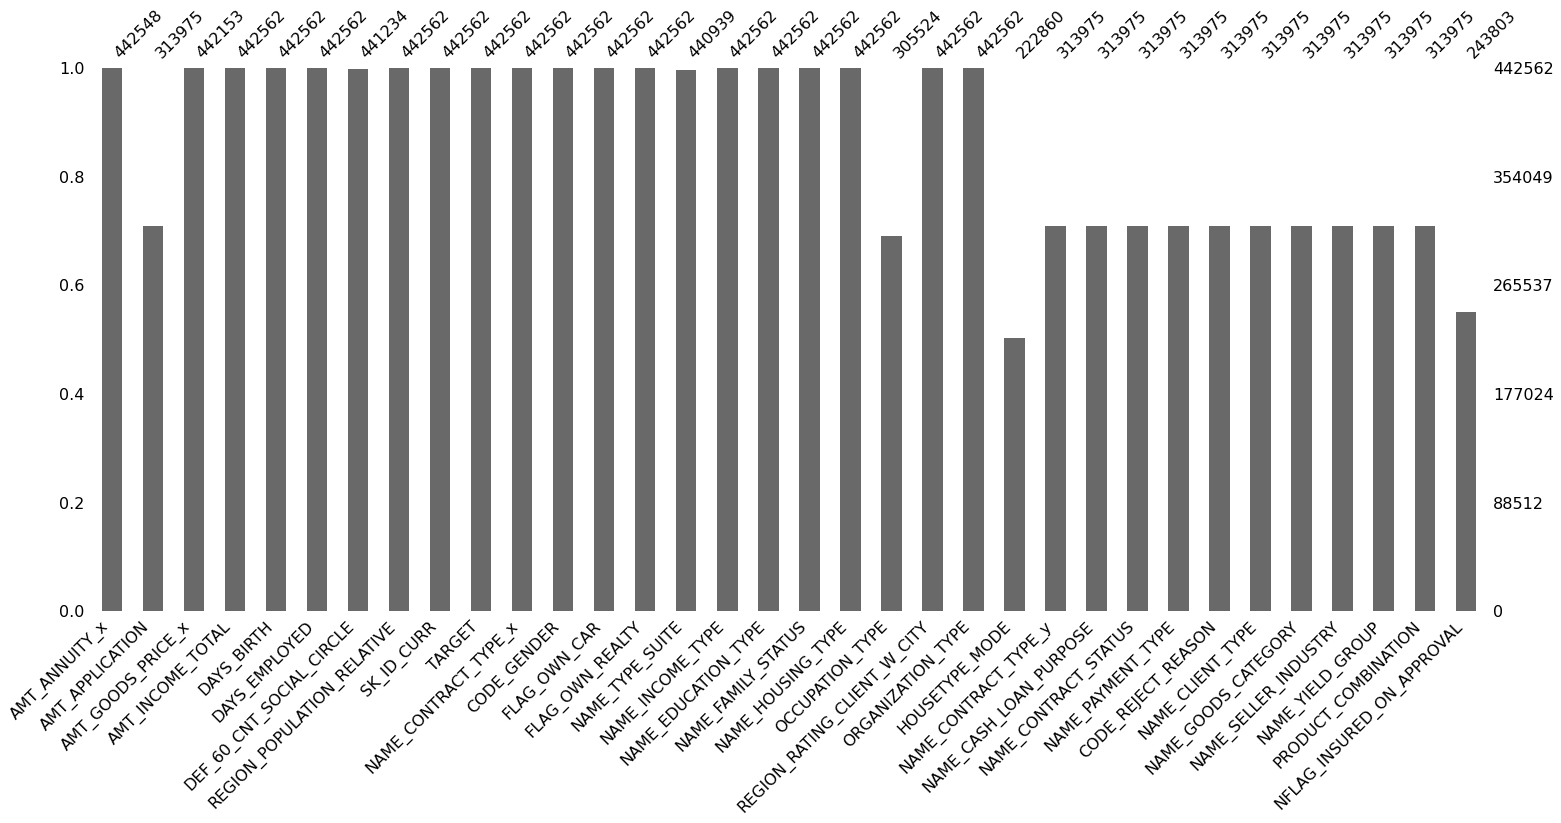

In [ ]:
msno.bar(NCB_test)

In [ ]:
NCB_test['OCCUPATION_TYPE'].unique()

['Laborers', 'Core staff', 'Accountants', 'Managers', NaN, ..., 'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff']
Length: 19
Categories (18, object): ['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff', ...,
                          'Sales staff', 'Secretaries', 'Security staff', 'Waiters/barmen staff']

In [ ]:
NCB_test['OCCUPATION_TYPE' == '...']

KeyError: ignored

In [ ]:
Past.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
       'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
       'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS',
       'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP',
       'PRODUCT_COMBINATION', 'NFLAG_INSURED_ON_APPROVAL'], dtype=object)

In [ ]:
HCD.isnull().sum()

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE                  0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT                          0
AMT_ANNUITY                        12
AMT_GOODS_PRICE                   278
NAME_TYPE_SUITE                  1292
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
OWN_CAR_AGE                    202929
OCCUPATION_TYPE                 96391
REGION_RATING_CLIENT_W_CITY         0
ORGANIZATION_TYPE                   0
HOUSETYPE_MODE                 154297
OBS_30_CNT_SOCIAL_CIRCLE         1021
DEF_30_CNT_SOCIAL_CIRCLE         1021
OBS_60_CNT_S

In [ ]:
Past.isnull().sum()

SK_ID_PREV                        0
SK_ID_CURR                        0
NAME_CONTRACT_TYPE                0
AMT_ANNUITY                   33388
AMT_APPLICATION                   0
AMT_CREDIT                        0
AMT_GOODS_PRICE                   0
RATE_INTEREST_PRIMARY        368875
RATE_INTEREST_PRIVILEGED     368875
NAME_CASH_LOAN_PURPOSE            0
NAME_CONTRACT_STATUS              0
NAME_PAYMENT_TYPE                 0
CODE_REJECT_REASON                0
NAME_CLIENT_TYPE                  0
NAME_GOODS_CATEGORY               0
NAME_SELLER_INDUSTRY              0
NAME_YIELD_GROUP                  0
PRODUCT_COMBINATION               0
NFLAG_INSURED_ON_APPROVAL     82447
dtype: int64

In [ ]:
NCB.isnull().sum()

SK_ID_CURR                          0
TARGET                              0
NAME_CONTRACT_TYPE_x                0
CODE_GENDER                         0
FLAG_OWN_CAR                        0
FLAG_OWN_REALTY                     0
CNT_CHILDREN                        0
AMT_INCOME_TOTAL                    0
AMT_CREDIT_x                        0
AMT_ANNUITY_x                      14
AMT_GOODS_PRICE_x                 409
NAME_TYPE_SUITE                  1623
NAME_INCOME_TYPE                    0
NAME_EDUCATION_TYPE                 0
NAME_FAMILY_STATUS                  0
NAME_HOUSING_TYPE                   0
REGION_POPULATION_RELATIVE          0
DAYS_BIRTH                          0
DAYS_EMPLOYED                       0
OWN_CAR_AGE                    287214
OCCUPATION_TYPE                137038
REGION_RATING_CLIENT_W_CITY         0
ORGANIZATION_TYPE                   0
HOUSETYPE_MODE                 219702
OBS_30_CNT_SOCIAL_CIRCLE         1328
DEF_30_CNT_SOCIAL_CIRCLE         1328
OBS_60_CNT_S

TypeError: ignored